# Clockwork Axion Cosmology

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import model
import plot_tools
import clock_work_axion
import reheating
import transport_equation
from common import constants, cosmology, util

In [32]:
import importlib
clock_work_axion = importlib.reload(clock_work_axion)

## Baryon Asymmmetry Generation

In [2]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6
m_phi = 100 * 1e-9 # [GeV]
eps = clock_work_axion.calc_eps(mR)
f = 1e12
f_eff = clock_work_axion.calc_f_eff(f, eps)
M = m_phi / eps

In [3]:
m = model.AxionBaryogenesisModel(
    source_vector=transport_equation.source_vector_weak_sphaleron, 
    get_axion_source=clock_work_axion.get_axion_source_clockwork,
    axion_rhs=clock_work_axion.rhs_log_t,
    calc_axion_mass=clock_work_axion.calc_mass,
    axion_parameter=(eps, M),
    axion_initial=(clock_work_axion.theta_to_phi_over_f(1.0, eps), 0),
    Gamma_phi=Gamma_phi,
    H_inf=H_inf,
)

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:74: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/master-project/transport_eq_in_time/plot_tools.py:29: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / source_scale


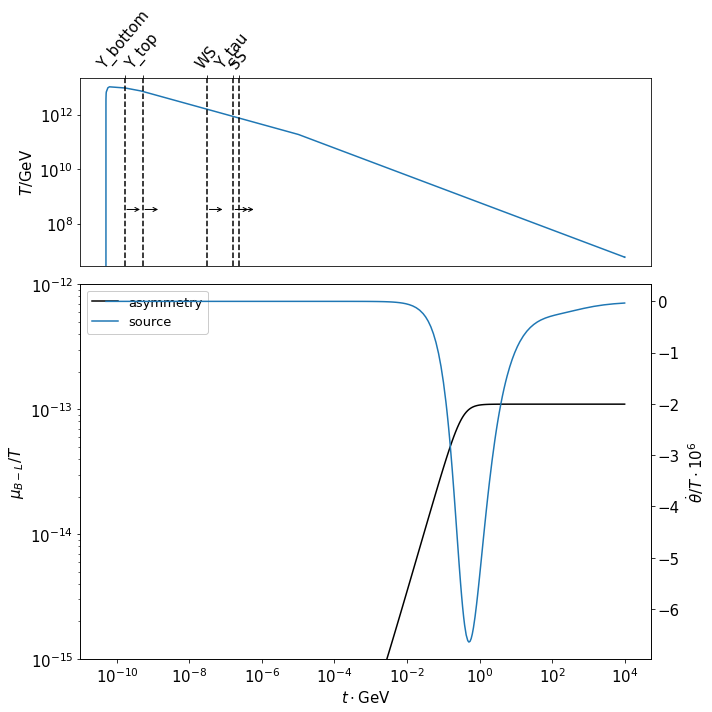

In [4]:
res = model.solve(m, collect=True, t_end=1e4)
plot_tools.plot(res, asymmetry_limits=(1e-15, 1e-12), source_scale=1e-9)

## Example Field Evolution

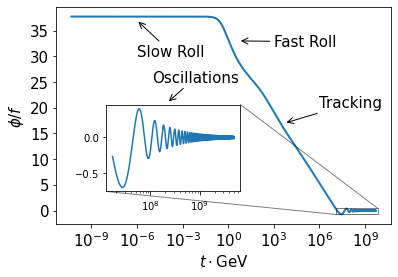

In [3]:
t0, initial = reheating.calc_initial_reheating(H_inf)
tf_2 = cosmology.switch_hubble_and_time_rad_dom(m_phi) * 1e3
T_fn, H_fn, _, final = reheating.solve_reheating_eq(t0, tf_2, initial, Gamma_phi)
sol = clock_work_axion.evolve(t0, tf_2, (clock_work_axion.theta_to_phi_over_f(1, eps), 0), (eps, M, H_fn))
plt.semilogx(sol.t, sol.y[0], lw=2)
plt.xlabel(r"$t \cdot \mathrm{GeV}$", fontsize=15)
plt.ylabel(r"$\phi / f$ ", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);
plt.annotate("Slow Roll", (1e-6, 37), (1e-6, 30), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Fast Roll", (5e0, 33), (1e3, 32), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Tracking", (0.5e4, 17), (1e6, 20), arrowprops=dict(arrowstyle="->"), fontsize=15)
plt.annotate("Oscillations", (1e-4, 21), (1e-5, 25), arrowprops=dict(arrowstyle="->"), fontsize=15)
ax = plt.gca()
i = np.where(sol.y[0] < 0)[0][0]
inset_ax = ax.inset_axes([0.15, 0.15, 0.4, 0.4])
inset_ax.semilogx(sol.t[i:], sol.y[0, i:])
ax.indicate_inset_zoom(inset_ax, edgecolor="black");

## Deformed Potentials

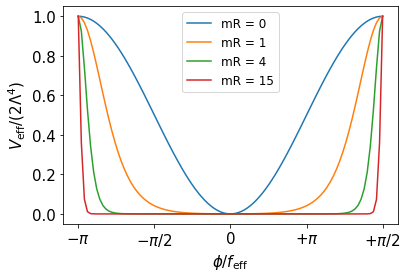

In [5]:
alpha_range = np.linspace(-np.pi, np.pi, 100)
for plot_mR in [0, 1, 4, 15]:
    eps = clock_work_axion.calc_eps(plot_mR)
    phi_over_f_range = clock_work_axion.calc_f_eff(f, eps) * alpha_range / f # not a linear map
    Lambda = np.sqrt(M * f)
    y = clock_work_axion.calc_V_eff_over_f_sq(phi_over_f_range, eps, M) * f**2 / (2*Lambda**4)
    y[0] = 1; y[-1] = 1 # okay this is bad
    plt.plot(alpha_range, y, label=f"mR = {plot_mR}")
plt.xlabel(r"$\phi / f_\mathrm{eff}$", fontsize=15)
plt.ylabel(r"$V_\mathrm{eff} / (2 \Lambda^4)$", fontsize=15)
plt.legend(fontsize=12)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", "0", r"$+\pi$", r"$+\pi/2$"], fontsize=15)
plt.yticks(fontsize=15);

## Parameterspace of the Clockwork Model

In [8]:
N = 30
m_phi_range = np.geomspace(1e-6, 1e6, N) * 1e-9 # [GeV]
mR_range = np.linspace(0, 15, N)
f_eff = 1e13
H_inf = 1e8
Gamma_phi = H_inf

In [9]:
%time obs = np.array([[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf, relic_kwargs=dict(max_steps=100)) for m_phi in m_phi_range] for mR in mR_range])

Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than

In [41]:
def plot_clockwork_parameter_space(m_phi_range, mR_range, obs, sim_f_eff, actuall_f_eff, H_inf):
    plt.figure(figsize=(8,4))
    num_lines = 10
    fts = 15
    inline_label_fs = 10

    # baryon asymmetry
    A = np.log10(obs[:, :, 0] / constants.eta_B_observed)
    level = np.sort(np.concatenate([[0], np.linspace(np.nanmin(A), np.nanmax(A), num_lines)]))
    C1 = plt.contour(m_phi_range * 1e9, mR_range, A, levels=level, cmap="viridis")
    cbar1 = plt.colorbar(pad=0.08)
    cbar1.set_label(r"$\log_{10} ( \eta_B / \eta_B^{\mathrm{obs}})$", fontsize=fts)
    C1.collections[np.where(C1.levels == 0)[0][0]].set_color("red")
    C1.collections[np.where(C1.levels == 0)[0][0]].set_linewidths(3)
    #plt.gca().clabel(C1, inline=True, fontsize=inline_label_fs)

    # relic density
    sim_f = np.array([clock_work_axion.calc_f(sim_f_eff, clock_work_axion.calc_eps(mR)) for mR in mR_range])[:, None]
    actuall_f = np.array([clock_work_axion.calc_f(actuall_f_eff, clock_work_axion.calc_eps(mR)) for mR in mR_range])[:, None]
    B = np.log10(obs[:, :, 1] / sim_f**2 * actuall_f**2 / constants.Omega_DM_h_sq)
    level = np.sort(np.concatenate([[0], np.linspace(np.nanmin(B), np.nanmax(B), num_lines)]))
    C2 = plt.contour(m_phi_range * 1e9, mR_range, B, levels=level, cmap="plasma", linestyles="--")
    cbar2 = plt.colorbar()
    cbar2.set_label(r"$\log_{10} ( \Omega_a / \Omega_a^{\mathrm{obs}})$", fontsize=fts)
    C2.collections[np.where(C2.levels == 0)[0][0]].set_linewidths(3)
    C2.collections[np.where(C2.levels == 0)[0][0]].set_color("red")
    #plt.gca().clabel(C2, inline=True, fontsize=inline_label_fs)

    # constrains 
    # interference with inflation
    plt.fill_between(m_phi_range * 1e9, [clock_work_axion.get_max_mR(m_phi, H_inf, 1.0) for m_phi in m_phi_range], [mR_range[-1]]*len(m_phi_range), 
                     color="blue", alpha=0.5)
    # decay
    plt.fill_between(m_phi_range * 1e9, [clock_work_axion.get_min_mR(m_phi, actuall_f_eff) for m_phi in m_phi_range], [mR_range[0]]*len(m_phi_range), 
                     color="green", alpha=0.5)

    plt.xlim(m_phi_range[0] * 1e9, m_phi_range[-1] * 1e9)
    plt.ylim(mR_range[0], mR_range[-1])
    plt.xlabel("$m_\phi$ / eV", fontsize=fts)
    plt.ylabel("mR", fontsize=fts)
    plt.xticks(fontsize=fts)
    plt.yticks(fontsize=fts)
    plt.xscale("log")
    plt.title(f"$f_\\mathrm{{eff}} = {util.latex_exponential_notation(actuall_f_eff, 2)}$ GeV", fontsize=fts)
    plt.tight_layout()

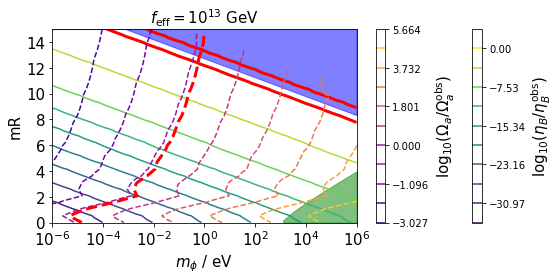

In [42]:
plot_clockwork_parameter_space(m_phi_range, mR_range, obs, f_eff, 1e13, H_inf)

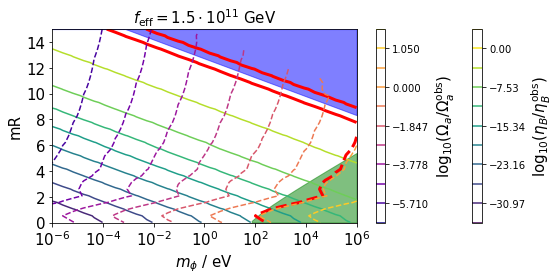

In [43]:
plot_clockwork_parameter_space(m_phi_range, mR_range, obs, f_eff, 1.5e11, H_inf)

In [49]:
%%time
mR_range_small = np.linspace(0, 4, 21)
m_phi_range_small = np.geomspace(1e-6, 1e6, 20)
obs_small_mR = np.array([[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf, relic_kwargs=dict(max_steps=100)) 
                          for m_phi in m_phi_range_small] for mR in mR_range_small])

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:75: RuntimeWarning: overflow encountered in exp
  t = np.exp(log_t)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:77: RuntimeWarning: overflow encountered in double_scalars
  return phi_dot_over_f * t, phi_dot_dot_over_f * t
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:35: RuntimeWarning: overflow encountered in exp
  _, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:55: RuntimeWarning: overflow encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:44: RuntimeWarning: invalid value encountered in double_scalars
  return eps / 2 * dn / cn**2
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:55: RuntimeWarning: invalid value en

CPU times: user 10min 3s, sys: 1.32 s, total: 10min 4s
Wall time: 10min 5s


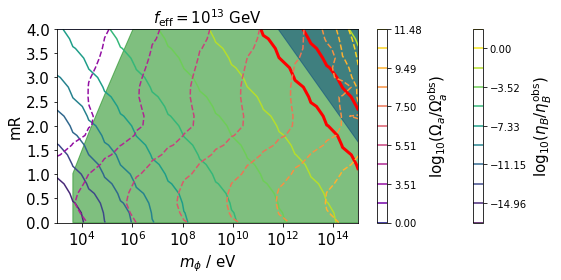

In [52]:
plot_clockwork_parameter_space(m_phi_range_small, mR_range_small, obs_small_mR, f_eff, f_eff, H_inf)
#plt.ylim(0,15)

## Dependence on Inflation Parameters $H_\mathrm{inf}$ and $\Gamma_\mathrm{inf}$ 

In [26]:
mR = 13
m_phi = 1e-1 * 1e-9
f_eff = 1e13
H_inf_range = [1e8, 1e10, 1e12]
Gamma_phi_over_H_inf_range = np.geomspace(1e-6, 1, 20)
obs_inf = [[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf) 
          for Gamma_phi in H_inf * Gamma_phi_over_H_inf_range] 
          for H_inf in H_inf_range]

/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:8: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:39: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:35: RuntimeWarning: overflow encountered in exp
  _, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: invalid value encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:105: RuntimeWarning: invalid value encountered in true_divide
  gamma = Gamma / (T**3 / 6) # rate per unit time
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: overflow encountered in double_scalars
  (Gamma_phi * rho_phi

Text(0.5, 1.0, '$mR = 13, m_\\phi = 10^{-1} $ eV')

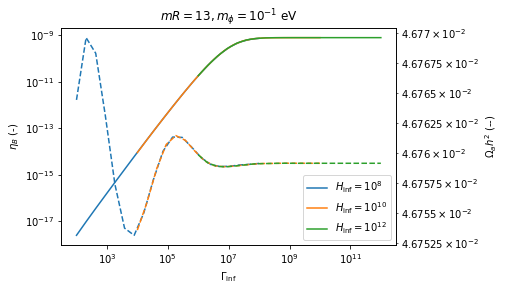

In [45]:
eta_label = r"$\eta_B$"
Omega_label = r"$\Omega_a h^2$"
plt.xlabel(r"$\Gamma_\mathrm{inf}$")
ax = plt.gca()
ax_twin = ax.twinx()
ax_twin.set_yscale("log")

for color, H_inf, O in zip(["tab:blue", "tab:orange", "tab:green"], H_inf_range, obs_inf):
    eta_inf, Omega_inf = np.array(O).T
    ax.loglog(H_inf * Gamma_phi_over_H_inf_range, eta_inf, label=f"$H_\\mathrm{{inf}} = {util.latex_exponential_notation(H_inf)}$", ls="-", color=color)
    ax_twin.plot(H_inf * Gamma_phi_over_H_inf_range, Omega_inf, ls="--", color=color)
    
ax_twin.set_ylabel(Omega_label)
ax.legend(loc=4)
ax.set_ylabel(eta_label + " (-)")
ax_twin.set_ylabel(Omega_label + " (--)")

plt.title(f"$mR = {mR}, m_\\phi = {util.latex_exponential_notation(m_phi * 1e9, 2)} $ eV")

## Parameterspace like in the default model

In [47]:
mR = 13
f_eff = 1e13
H_inf = 1e10
obs_std_param_space = np.array([[clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf) 
                        for m_phi in m_phi_range] for Gamma_phi in H_inf * Gamma_phi_over_H_inf_range])

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:48: RuntimeWarning: overflow encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.


/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:8: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(y)
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:39: RuntimeWarning: overflow encountered in exp
  rho_phi, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:35: RuntimeWarning: overflow encountered in exp
  _, rho_tot = np.exp(sol.sol(np.log(t)))
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: invalid value encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:105: RuntimeWarning: invalid value encountered in true_divide
  gamma = Gamma / (T**3 / 6) # rate per unit time


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:182: RuntimeWarning: invalid value encountered in multiply
  - (rate(T) * (charge_vector @ red_chem_pots - n_S * theta_dot / T / unit)) @ charge_vector / dofs
/home/jana/Documents/master-project/transport_eq_in_time/transport_equation.py:182: RuntimeWarning: invalid value encountered in matmul
  - (rate(T) * (charge_vector @ red_chem_pots - n_S * theta_dot / T / unit)) @ charge_vector / dofs
/home/jana/Documents/master-project/transport_eq_in_time/reheating.py:42: RuntimeWarning: overflow encountered in double_scalars
  (Gamma_phi * rho_phi - 4 * H_fn(t) * rho_rad) /


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.


/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:68: RuntimeWarning: invalid value encountered in double_scalars
  1 / MM * np.abs(calc_dV_eff_dphi_over_f(phi_over_f, eps, M)) * phi_dot_over_f


Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than spacing between numbers.
Required step size is less than

<ipython-input-49-00a4c33e2209>:1: RuntimeWarning: invalid value encountered in log10
  plt.contour(m_phi_range * 1e9, H_inf * Gamma_phi_over_H_inf_range, np.log10(obs_std_param_space[:, :, 0] / constants.eta_B_observed))


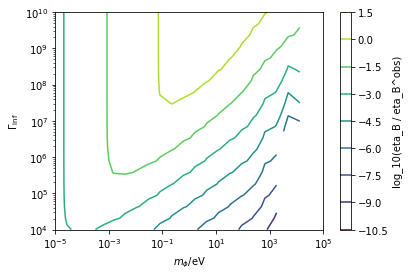

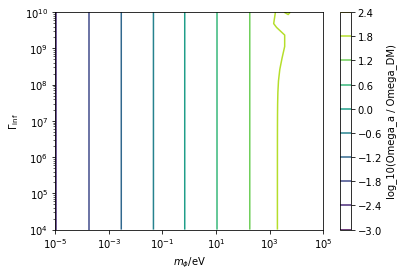

In [49]:
plt.contour(m_phi_range * 1e9, H_inf * Gamma_phi_over_H_inf_range, np.log10(obs_std_param_space[:, :, 0] / constants.eta_B_observed))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\phi / \mathrm{eV}$")
plt.ylabel(r"$\Gamma_\mathrm{inf}$")
plt.colorbar().set_label("log_10(eta_B / eta_B^obs)")
plt.show()
plt.contour(m_phi_range * 1e9, H_inf * Gamma_phi_over_H_inf_range, np.log10(obs_std_param_space[:, :, 1] / constants.Omega_DM_h_sq))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_\phi / \mathrm{eV}$")
plt.ylabel(r"$\Gamma_\mathrm{inf}$")
plt.colorbar().set_label("log_10(Omega_a / Omega_DM)")

## Dependence on $\theta_i$

In [2]:
theta_range = np.linspace(0, np.pi - 1e-3, 20)
mR = 13
m_phi = 1e-1 * 1e-9
f_eff = 1e13
Gamma_phi = H_inf = 1e8
obs_theta = np.array([clock_work_axion.compute_observables(m_phi, mR, f_eff, Gamma_phi, H_inf, theta_i=theta_i) for theta_i in theta_range])

/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)
/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py:48: RuntimeWarning: invalid value encountered in double_scalars
  return 4 * M**2 * calc_du_dphi_times_f(phi_over_f, eps) / (u**3 * (1 + 1 / u**2)**2)


Required step size is less than spacing between numbers.


Text(0.5, 1.0, '$mR = 13, m_\\phi = 10^{-1} $ eV')

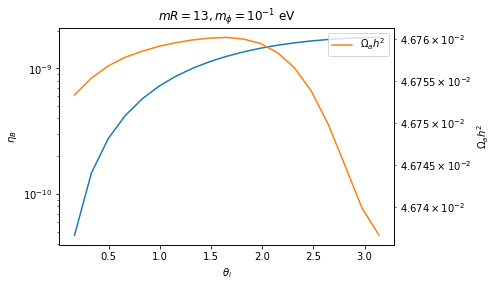

In [25]:
eta_B_theta, Omega_a_h_sq_theta = obs_theta.T
plt.semilogy(theta_range, eta_B_theta, label=eta_label, color="tab:blue")
plt.xlabel("$\\theta_i$")
plt.ylabel(eta_label)
ax_twin = plt.gca().twinx()
ax_twin.set_yscale("log")
ax_twin.plot(theta_range, Omega_a_h_sq_theta, label=Omega_label, color="tab:orange")
ax_twin.set_ylabel(Omega_label)
plt.legend()
plt.title(f"$mR = {mR}, m_\\phi = {util.latex_exponential_notation(m_phi * 1e9, 2)} $ eV")

## Experimental Detection

In [12]:
e_sq = (constants.g_1 * constants.g_2)**2 / (constants.g_1**2 + constants.g_2**2)
def calc_axion_photon_coupling(mR, f_eff):
    eps = clock_work_axion.calc_eps(mR)
    f = clock_work_axion.calc_f(f_eff, eps)
    return e_sq * eps / (16*np.pi**2 * f)

Text(0, 0.5, 'g_phi,gamma [1/GeV]')

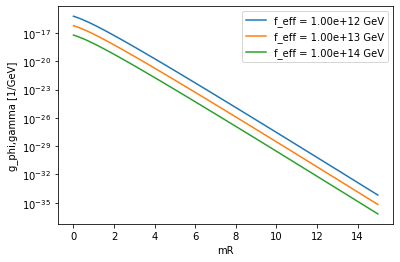

In [17]:
mR_range = np.linspace(0, 15, 100)
for f_eff in [1e12, 1e13, 1e14]:
    plt.semilogy(mR_range, calc_axion_photon_coupling(mR_range, f_eff), label=f"f_eff = {f_eff:.2e} GeV")
plt.xlabel("mR")
plt.legend()
plt.ylabel("g_phi,gamma [1/GeV]")

![axion experiments](../exclusion.png)

In [6]:
sin_sq_theta_w = 0.22290
theta_w = np.arcsin(np.sqrt(sin_sq_theta_w))

In [7]:
np.sin(theta_w) * constants.g_2 

0.3078241082176638

In [8]:
np.cos(theta_w) * constants.g_1

0.3147071939120553

## Optimize the Relic density solver

In [46]:
clock_work_axion = importlib.reload(clock_work_axion)

In [45]:
mR = 1
clock_work_axion.compute_relic_density()

<module 'clock_work_axion' from '/home/jana/Documents/master-project/transport_eq_in_time/clock_work_axion.py'>